## Petrophysical properties inversion from seismic data

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
from random import randint
from wiggle.wiggle import wiggle
from matplotlib.pyplot import figure
import math
import tensorflow as tf

In [2]:
# Checking the devices available for use in AWS
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7031060122247999484
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8729873119454011976
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8312549208523254741
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11326753997
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8273839385506402908
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
# Loading the Vp, Vs and Density data

dataframe = sio.loadmat('../../../Data_generation_base_case/Train_DataSyn1_time_clip.mat')
Vp = dataframe['VpMat']
Vp = np.reshape(Vp, (Vp.shape[0]*Vp.shape[1], Vp.shape[2]))
Vs = dataframe['VsMat']
Vs = np.reshape(Vs, (Vs.shape[0]*Vs.shape[1], Vs.shape[2]))
RHOB = dataframe['RHOBMat']
RHOB = np.reshape(RHOB, (RHOB.shape[0]*RHOB.shape[1], RHOB.shape[2]))

depth = dataframe['depthVec']

# Loading facies, porosity, vclay and water saturation data 
dataframe_facies = sio.loadmat('../../../Data_generation_base_case/Train_FaciesMat.mat')
facies = dataframe_facies['zFaciesMat']
facies = np.reshape(facies, (facies.shape[0]*facies.shape[1], facies.shape[2]))

dataframe_porosity = sio.loadmat('../../../Data_generation_base_case/Train_PhiMat.mat')
porosity = dataframe_porosity['zPhiMat']
porosity = np.reshape(porosity, (porosity.shape[0]*porosity.shape[1], porosity.shape[2]))

dataframe_vclay = sio.loadmat('../../../Data_generation_base_case/Train_ClayMat.mat')
vclay = dataframe_vclay['zClayMat']
vclay = np.reshape(vclay, (vclay.shape[0]*vclay.shape[1], vclay.shape[2]))

dataframe_Sw = sio.loadmat('../../../Data_generation_base_case/Train_SwMat.mat')
Sw = dataframe_Sw['zSwMat']
Sw = np.reshape(Sw, (Sw.shape[0]*Sw.shape[1], Sw.shape[2]))


Text(0.5,0,'Ip')

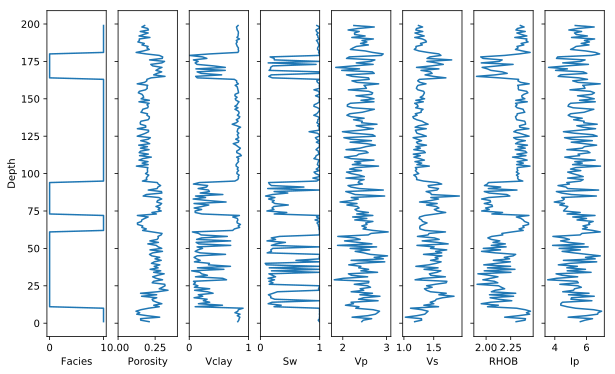

In [4]:
# Plot of loaded data

sample_number = 12
f, axarr = plt.subplots(1, 8, sharey = True, figsize=(10,6))

axarr[0].plot(facies[sample_number, :], depth)
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth")

axarr[1].plot(porosity[sample_number, :], depth)
axarr[1].set_xlabel("Porosity")
axarr[1].set_xlim(0,0.4)

axarr[2].plot(vclay[sample_number, :], depth)
axarr[2].set_xlabel("Vclay")
axarr[2].set_xlim(0,1)

axarr[3].plot(Sw[sample_number, :], depth)
axarr[3].set_xlabel("Sw")
axarr[3].set_xlim(0,1)

axarr[4].plot(Vp[sample_number, :], depth)
axarr[4].set_xlabel("Vp")
# plt.xlim(0,1)

axarr[5].plot(Vs[sample_number, :], depth)
axarr[5].set_xlabel("Vs")
# plt.xlim(0,1)

axarr[6].plot(RHOB[sample_number, :], depth)
axarr[6].set_xlabel("RHOB")
# plt.xlim(0,1)

axarr[7].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
axarr[7].set_xlabel("Ip")

Text(0.5,0,'Vp/Vs')

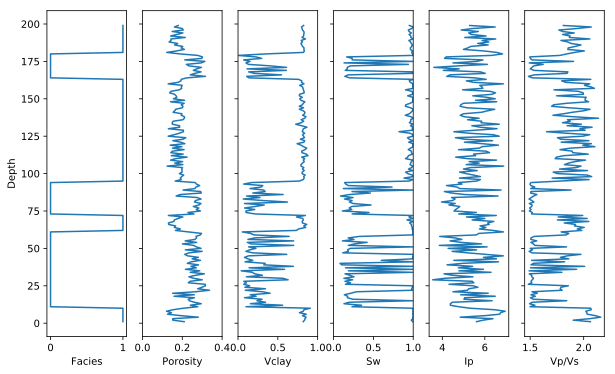

In [5]:
sample_number = 12
f, axarr = plt.subplots(1, 6, sharey = True, figsize=(10,6))

axarr[0].plot(facies[sample_number, :], depth)
axarr[0].set_xlabel("Facies")
axarr[0].set_ylabel("Depth")

axarr[1].plot(porosity[sample_number, :], depth)
axarr[1].set_xlabel("Porosity")
axarr[1].set_xlim(0,0.4)

axarr[2].plot(vclay[sample_number, :], depth)
axarr[2].set_xlabel("Vclay")
axarr[2].set_xlim(0,1)

axarr[3].plot(Sw[sample_number, :], depth)
axarr[3].set_xlabel("Sw")
axarr[3].set_xlim(0,1)

axarr[4].plot(Vp[sample_number, :]*RHOB[sample_number, :], depth)
axarr[4].set_xlabel("Ip")

axarr[5].plot(Vp[sample_number, :]/Vs[sample_number, :], depth)
axarr[5].set_xlabel("Vp/Vs")

In [6]:
# AVO and source parameters 
src_len=np.int(60)
freq=40
dt=7e-4
# ntheta=46
thetaStart=0
thetaEnd=30
thetaInc=5
theta=np.arange(thetaStart,thetaEnd+thetaInc,thetaInc)
ntheta=theta.size
# nt=201
# ncdp=1111
angle=np.reshape(theta,[1,ntheta])
# theta=np.arange(0,ntheta,1)
print('angle:', angle.shape)
print('angle:', angle)

angle: (1, 7)
angle: [[ 0  5 10 15 20 25 30]]


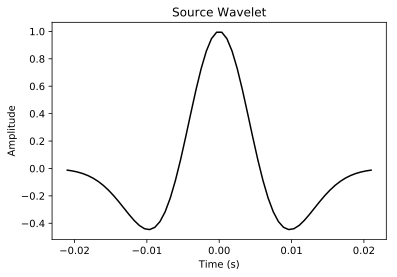

In [8]:
# Generate the seismic wavelet
def ricker(f,n,dt,t0):

    T = dt*(np.floor(n/2));
    t = np.linspace(-T,T,n)
    tau = t-t0;
    pi=np.pi
    s = (1-2*tau*tau*f**2*pi**2)*np.exp(-tau**2*pi**2*f**2);
    rw = s;

    return rw,t
src,tsrc=ricker(freq,src_len,dt,0)
plt.plot(tsrc,src, '-k')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Source Wavelet")
plt.show()

In [7]:
# Full Zoeppritz using tensorflow

def gather(input1,tftheta,tfsrc):
    print('input1:',input1)
    vp = tf.expand_dims(input1[:,:,0],2)
    vs = tf.expand_dims(input1[:,:,1],2)
    rho = tf.expand_dims(input1[:,:,2],2)
    vp=tf.check_numerics(vp,"Nan at vp start")
    vs=tf.check_numerics(vs,"Nan at vp start")
    rho=tf.check_numerics(rho,"Nan at vp start")
    

    nref= tf.shape(input1)[1]#vp.get_shape()[1]#.as_list()[1]
    bs=tf.shape(input1)[0]
    ntheta=tf.shape(tftheta)[1]
    #nt=tf.shape(input1)[1]
    
    tfzero=tf.zeros([bs,1,ntheta], dtype=tf.float32)
    
    tfangle = tf.expand_dims(tf.convert_to_tensor(tftheta, 
                                                  dtype=tf.float32),0)
    tfangle=tf.tile(tfangle,[bs,nref-1,1])

  
    vp1=tf.tile(vp[:,0:nref-1],[1, 1, ntheta])
    vs1=tf.tile(vs[:,0:nref-1],[1, 1, ntheta])
    d1=tf.tile(rho[:,0:nref-1],[1, 1, ntheta])

    vp2=tf.tile(vp[:,1:nref],[1, 1, ntheta])
    vs2=tf.tile(vs[:,1:nref],[1, 1, ntheta])
    d2=tf.tile(rho[:,1:nref],[1, 1, ntheta])
    
    
    vpj1=tf.complex(vp1,tf.zeros_like(vp1))
    vsj1=tf.complex(vs1,tf.zeros_like(vs1))
    dj1=tf.complex(d1,tf.zeros_like(d1))

    vpj2=tf.complex(vp2,tf.zeros_like(vp2))
    vsj2=tf.complex(vs2,tf.zeros_like(vs2))
    dj2=tf.complex(d2,tf.zeros_like(d2))
    
    
    t=tf.scalar_mul(np.pi/180,tfangle)    
    p=tf.divide(tf.sin(t),vp1)
    ct=tf.cos(t)
    
    sint=tf.complex(tf.sin(t),tf.zeros_like(t))
    
    # FULL ZOEPPRITZ
    ct2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vpj2),tf.square(vpj1))))))
    
    cj1=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj1),tf.square(vpj1))))))
    
    cj2=tf.real(tf.sqrt(np.subtract(1+0j,tf.multiply(tf.square(sint)
                , tf.divide(tf.square(vsj2),tf.square(vpj1))))))
    
    a=tf.subtract(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p)))))
            )
    
    b=tf.add(
            tf.multiply(d2, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))),
            tf.multiply(d1,tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))
            )
    c=tf.add(
            tf.multiply(d1, tf.subtract(1.0, tf.scalar_mul(2.0,tf.multiply(tf.square(vs1), tf.square(p))))),
            tf.multiply(d2,tf.scalar_mul(2.0,tf.multiply(tf.square(vs2), tf.square(p))))
            )
    
    d=tf.scalar_mul(2.0, 
            tf.subtract(
                    tf.multiply(d2,tf.square(vs2)),
                    tf.multiply(d1,tf.square(vs1)))
            )
            
    E=tf.add(
            tf.multiply(b,tf.divide(ct,vp1)),
            tf.multiply(c,tf.divide(ct2,vp2))
            )
    F=tf.add(
            tf.multiply(b,tf.divide(cj1,vs1)),
            tf.multiply(c,tf.divide(cj2,vs2))
            )
    G=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct,cj2)),
                          tf.multiply(vp1,vs2))
                  )
    H=tf.subtract(a,
                  tf.divide(
                          tf.multiply(d,tf.multiply(ct2,cj1)),
                          tf.multiply(vp2,vs1))
                  )
    D=tf.add(
            tf.multiply(E,F),
            tf.multiply(G,tf.multiply(H,tf.square(p)))
            )
    
    Rpp=tf.real(tf.divide(tf.subtract(
            tf.multiply(tf.subtract( tf.multiply(b,tf.divide(ct,vp1)), tf.multiply(c,tf.divide(ct2,vp2))),F),
            tf.multiply( tf.add(a, tf.multiply(d,tf.multiply(ct,tf.divide(cj2,tf.multiply(vp1,vs2))))) ,tf.multiply(H,tf.square(p)))            
            ),D))
    #print('Rpp1:',Rpp)
    Rpp=tf.concat([Rpp,tfzero],1)
    #print('Rpp2:',Rpp)
    # Rpp1=tf.zeros()
    Rpp1=tf.expand_dims(Rpp,axis=3)
    #Rpp1=tf.where(tf.is_nan(Rpp1), tf.zeros_like(Rpp1), Rpp1)
    #print('Rpp11:',Rpp1)
    #print('tfsrc:',tfsrc)
    seis=tf.transpose(tf.nn.conv2d(Rpp1,tfsrc,strides=[1,1,1,1],padding='SAME'),perm=[0,2,1,3])
    #print("seis:",seis)
    seis=tf.reshape(seis,[-1,nt*ntheta])
    #seis=tf.Print(seis,[tf.shape(seis)])

    #print('seis:',seis)
    
    return seis,Rpp

In [9]:
# Convert Vp, Vs and Density logs from depth to time 
time = np.zeros((Vp.shape[0], Vp.shape[1]+1))

for i in range(time.shape[0]):
    depth_diff = np.mean(np.diff(depth.T))
    time[i,0] = 0
    time[i,1:] = 2*np.cumsum(depth_diff/(Vp[i,:]*1e3))

time = time[:,0:-1]
# Interpolate the time values such that all logs have the same dt_log
end_time = (np.max(time))
time_upscaled = np.arange(0, end_time, dt)

Vp_time = np.zeros((Vp.shape[0], time_upscaled.shape[0]))
Vs_time = np.zeros((Vs.shape[0], time_upscaled.shape[0]))
RHOB_time = np.zeros((RHOB.shape[0], time_upscaled.shape[0]))
for i in range(time.shape[0]):
    Vp_time[i,:] = np.interp(time_upscaled, time[i,:], Vp[i,:])
    Vs_time[i,:] = np.interp(time_upscaled, time[i,:], Vs[i,:])
    RHOB_time[i,:] = np.interp(time_upscaled, time[i,:], RHOB[i,:])
    
nt = time_upscaled.shape[0]    

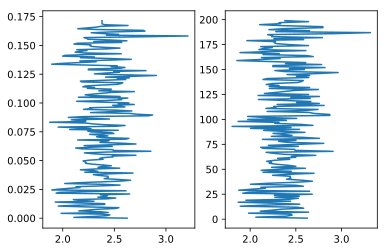

In [10]:
sample_number = 10
plt.subplot(1,2,1)
plt.plot(Vp_time[sample_number,:], time_upscaled)
plt.subplot(1,2,2)
plt.plot(Vp[sample_number,:], depth)


input1: Tensor("Const:0", shape=(2500, 246, 3), dtype=float32)


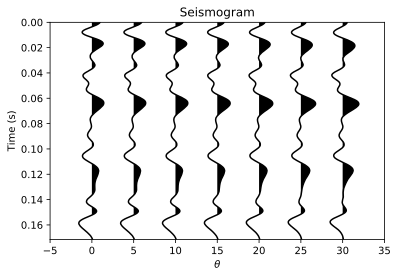

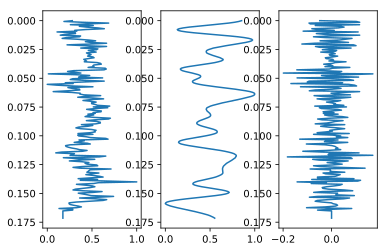

In [10]:
# Forward modeling results (Seismic gathers) (DONOT RUN IF NEW DATA IS NOT GENERATED)

# Test the forward modeling
bs=Vp_time.shape[0]
input11=np.zeros([bs,nt,3],dtype=np.float32)

input11[0:bs,:,0]=Vp_time[0:bs,:]
input11[0:bs,:,1]=Vs_time[0:bs,:]
input11[0:bs,:,2]=RHOB_time[0:bs,:]
# plt.plot(np.squeeze(input11))
# plt.show()

input111=tf.convert_to_tensor(input11,dtype=tf.float32)
# print("src:",src.shape)


tfsrc=tf.reshape(tf.constant(src,dtype=tf.float32),[src_len,1,1,1])


# print('tfsrc:',tfsrc)
# print('angle:',angle.shape)
tftheta=tf.convert_to_tensor(angle,dtype=tf.float32)
# print('tftheta:',tftheta)
seisgen=gather(input111,tftheta,tfsrc)


sess=tf.Session()
seis11,Rpp11=sess.run(seisgen)

sess.close()

seis=np.transpose(np.reshape(seis11,[-1,ntheta,nt]),[0,2,1])
Rpp=Rpp11#np.reshape(Rpp11,[bs,nt,ntheta])

sample_number = 20
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

In [16]:
# Exporting generated seismic data
np.save('../../../Data_generation_base_case/seismic_forward_modeled.npy', seis)
np.save('../../../Data_generation_base_case/Rpp_forward_modeled.npy', Rpp)


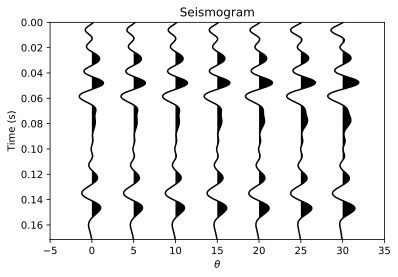

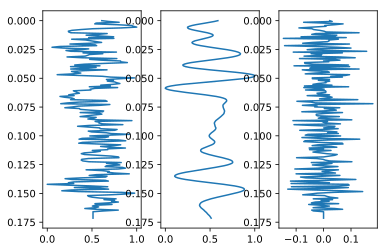

In [11]:
# Load forward modeled seismic data and Rpp
seis = np.load('../../../Data_generation_base_case/seismic_forward_modeled.npy')
Rpp = np.load('../../../Data_generation_base_case/Rpp_forward_modeled.npy')

sample_number = 12
wiggle(np.squeeze(seis[sample_number,:,:]),time_upscaled,theta)
plt.title("Seismogram")
plt.xlabel("$\\theta$")
plt.ylabel("Time (s)")
plt.show()

impedance_time = Vp_time * RHOB_time
impedance_time_sample = impedance_time[sample_number,:]
plt.subplot(1,3,1)
plt.plot((impedance_time_sample - np.min(impedance_time_sample))/(np.max(impedance_time_sample)-np.min(impedance_time_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,2)
seis_sample = np.squeeze(seis[sample_number,:,0])
plt.plot((seis_sample - np.min(seis_sample))/(np.max(seis_sample) - np.min(seis_sample)), time_upscaled)
plt.gca().invert_yaxis()
plt.subplot(1,3,3)
plt.plot(np.squeeze(Rpp[sample_number,:,0]), time_upscaled)
plt.gca().invert_yaxis()

In [12]:
# Import keras modules for CNN

from keras import layers, initializers, optimizers
from keras.layers import Input, Dense, Activation, ZeroPadding1D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling1D, MaxPooling2D, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers import LeakyReLU, Reshape
from keras.models import Model, model_from_json, load_model
from keras.preprocessing import image
from keras.utils import layer_utils, normalize
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
# from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')

import sklearn.model_selection
import pydot

Using TensorFlow backend.


In [13]:
# Getting the input data (normalized) and output data 

# Reshape seismic gathers into (number of examples, angle, time) and normalize such that seismic traces have positive values
seis_reshaped = np.swapaxes(seis,1,2)
# seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))
# Normalizing each trace individually
seis_test = np.reshape(seis_reshaped, (seis_reshaped.shape[0]*seis_reshaped.shape[1], seis_reshaped.shape[2]))
seis_reshaped_normalized = np.transpose(
    (seis_test.T - np.min(seis_test, axis=1))/(np.max(seis_test, axis=1) - np.min(seis_test, axis=1)))
seis_reshaped_normalized = np.reshape(seis_reshaped_normalized, (seis_reshaped.shape[0], seis_reshaped.shape[1], seis_reshaped.shape[2]))

# Selecting near(0 degree) and far (30 degree) angle traces from the full seismic gathers
row_idx = np.array([0, 6])
angle_seis_reshaped_normalized = seis_reshaped_normalized[:,row_idx,:]

# Output as Ip, Vp_Vs ratio
num_examples = Vp_time.shape[0]

# # Normalize Vp, Vs and Density
# Vp_time_norm = (Vp_time - np.min(Vp_time))/(np.max(Vp_time) - np.min(Vp_time))
# Vs_time_norm = (Vs_time - np.min(Vs_time))/(np.max(Vs_time) - np.min(Vs_time))
# RHOB_time_norm = (RHOB_time - np.min(RHOB_time))/(np.max(RHOB_time) - np.min(RHOB_time))

emodel = np.concatenate((Vp_time*RHOB_time,Vp_time/Vs_time), axis=1)
# emodel = np.concatenate((Vp_time_norm,Vs_time_norm,RHOB_time_norm), axis=1)
emodel = emodel.reshape((num_examples, 2, nt))


# Split data into train and test set - elastic model
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(angle_seis_reshaped_normalized, 
                                                                            emodel, test_size=0.2, random_state=1)
# X_train, X_test, Y_train_norm, Y_test_norm = sklearn.model_selection.train_test_split(angle_seis_reshaped_normalized, 
#                                                                             emodel, test_size=0.2, random_state=1)


# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)


print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
# print ("Y_train shape: " + str(Y_train_norm.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
# print ("Y_test shape: " + str(Y_test_norm.shape))

number of training examples = 2000
number of test examples = 500
X_train shape: (2000, 2, 246, 1)
Y_train shape: (2000, 2, 246)
X_test shape: (500, 2, 246, 1)
Y_test shape: (500, 2, 246)


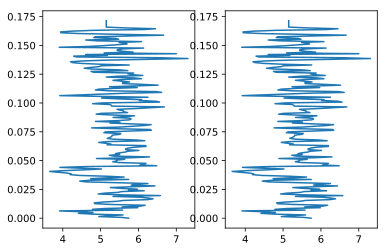

In [14]:
sample_number = 10

plt.subplot(1,2,1)
plt.plot(Y_train[sample_number, 0, :], time_upscaled)

plt.subplot(1,2,2)
plt.plot(Y_train[sample_number, 0, :], time_upscaled)

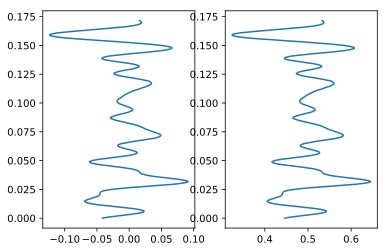

In [15]:
seis_reshaped_normalized = (seis_reshaped - np.min(seis_reshaped))/(np.max(seis_reshaped)-np.min(seis_reshaped))

plt.subplot(1,2,1)
plt.plot(np.squeeze(seis_reshaped[2,1,:]),time_upscaled)
plt.subplot(1,2,2)
plt.plot(np.squeeze(seis_reshaped_normalized[2,1,:]),time_upscaled)

In [16]:
# Building neural network for elastic properties prediction in Keras 
given_seed = 3 # For repeatibility

def elasticnet(input_shape):
    """
    Implementation of the AVONet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(60, (1, 60), strides=(1, 1), name='conv0', padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv0')(X)
    # MAXPOOL
#     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(1, (1, 60), strides=(1, 1), name='conv1', padding='same',
               kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv1')(X)
    # MAXPOOL
#     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)
      

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
#     X = Dense(200, name='fc0',
#              kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
#     X = Activation('relu')(X)
    X = Dense(246*2, name='fc1',
             kernel_initializer=initializers.glorot_uniform(seed=given_seed), bias_initializer='zeros')(X)
    X = Activation('relu')(X)
    X = Reshape((2, 246))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='ElasticModel')

    return model
    ### END CODE HERE ###

In [17]:
# Create the model
ElasticModel = elasticnet(X_train.shape[1:])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [18]:
# Summary and plot of the model

ElasticModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 2, 246, 60)        3660      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 2, 246, 60)        240       
_________________________________________________________________
activation_1 (Activation)    (None, 2, 246, 60)        0         
_________________________________________________________________
drop_conv0 (Dropout)         (None, 2, 246, 60)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 246, 1)         3601      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 246, 1)         4         
__________

In [80]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 500.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [19]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticModel.compile(loss='mean_squared_error', optimizer = adam)

In [20]:
# Removing previous best_model.h5 file
import os
os.remove("best_model_elastic_near_far.h5")

In [21]:
# Using early stopping and Model Checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=250)
mc = ModelCheckpoint('best_model_elastic_near_far.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [22]:
# Start the training
# Using learning rate scheduler
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [es, mc, lrate]
# history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, 
#                            epochs=1500, batch_size=32, callbacks=callbacks_list, verbose=0)

history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, 
                           epochs=1500, batch_size=32, callbacks=[es, mc],
                          verbose = 0)

Instructions for updating:
Use tf.cast instead.

Epoch 00001: val_loss improved from inf to 0.79944, saving model to best_model_elastic_near_far.h5

Epoch 00002: val_loss improved from 0.79944 to 0.34662, saving model to best_model_elastic_near_far.h5

Epoch 00003: val_loss improved from 0.34662 to 0.31481, saving model to best_model_elastic_near_far.h5

Epoch 00004: val_loss improved from 0.31481 to 0.26104, saving model to best_model_elastic_near_far.h5

Epoch 00005: val_loss improved from 0.26104 to 0.25444, saving model to best_model_elastic_near_far.h5

Epoch 00006: val_loss improved from 0.25444 to 0.24923, saving model to best_model_elastic_near_far.h5

Epoch 00007: val_loss improved from 0.24923 to 0.21704, saving model to best_model_elastic_near_far.h5

Epoch 00008: val_loss did not improve from 0.21704

Epoch 00009: val_loss did not improve from 0.21704

Epoch 00010: val_loss did not improve from 0.21704

Epoch 00011: val_loss improved from 0.21704 to 0.19835, saving model to


Epoch 00130: val_loss did not improve from 0.15897

Epoch 00131: val_loss improved from 0.15897 to 0.15826, saving model to best_model_elastic_near_far.h5

Epoch 00132: val_loss did not improve from 0.15826

Epoch 00133: val_loss did not improve from 0.15826

Epoch 00134: val_loss did not improve from 0.15826

Epoch 00135: val_loss did not improve from 0.15826

Epoch 00136: val_loss did not improve from 0.15826

Epoch 00137: val_loss did not improve from 0.15826

Epoch 00138: val_loss did not improve from 0.15826

Epoch 00139: val_loss did not improve from 0.15826

Epoch 00140: val_loss did not improve from 0.15826

Epoch 00141: val_loss did not improve from 0.15826

Epoch 00142: val_loss did not improve from 0.15826

Epoch 00143: val_loss improved from 0.15826 to 0.15775, saving model to best_model_elastic_near_far.h5

Epoch 00144: val_loss did not improve from 0.15775

Epoch 00145: val_loss did not improve from 0.15775

Epoch 00146: val_loss did not improve from 0.15775

Epoch 00147


Epoch 00275: val_loss did not improve from 0.15257

Epoch 00276: val_loss improved from 0.15257 to 0.15180, saving model to best_model_elastic_near_far.h5

Epoch 00277: val_loss did not improve from 0.15180

Epoch 00278: val_loss did not improve from 0.15180

Epoch 00279: val_loss did not improve from 0.15180

Epoch 00280: val_loss did not improve from 0.15180

Epoch 00281: val_loss did not improve from 0.15180

Epoch 00282: val_loss did not improve from 0.15180

Epoch 00283: val_loss did not improve from 0.15180

Epoch 00284: val_loss did not improve from 0.15180

Epoch 00285: val_loss did not improve from 0.15180

Epoch 00286: val_loss did not improve from 0.15180

Epoch 00287: val_loss did not improve from 0.15180

Epoch 00288: val_loss did not improve from 0.15180

Epoch 00289: val_loss did not improve from 0.15180

Epoch 00290: val_loss did not improve from 0.15180

Epoch 00291: val_loss did not improve from 0.15180

Epoch 00292: val_loss did not improve from 0.15180

Epoch 00293


Epoch 00423: val_loss did not improve from 0.14879

Epoch 00424: val_loss did not improve from 0.14879

Epoch 00425: val_loss did not improve from 0.14879

Epoch 00426: val_loss improved from 0.14879 to 0.14860, saving model to best_model_elastic_near_far.h5

Epoch 00427: val_loss did not improve from 0.14860

Epoch 00428: val_loss did not improve from 0.14860

Epoch 00429: val_loss did not improve from 0.14860

Epoch 00430: val_loss improved from 0.14860 to 0.14845, saving model to best_model_elastic_near_far.h5

Epoch 00431: val_loss did not improve from 0.14845

Epoch 00432: val_loss did not improve from 0.14845

Epoch 00433: val_loss improved from 0.14845 to 0.14807, saving model to best_model_elastic_near_far.h5

Epoch 00434: val_loss did not improve from 0.14807

Epoch 00435: val_loss did not improve from 0.14807

Epoch 00436: val_loss did not improve from 0.14807

Epoch 00437: val_loss did not improve from 0.14807

Epoch 00438: val_loss did not improve from 0.14807

Epoch 00439


Epoch 00570: val_loss did not improve from 0.14551

Epoch 00571: val_loss did not improve from 0.14551

Epoch 00572: val_loss did not improve from 0.14551

Epoch 00573: val_loss did not improve from 0.14551

Epoch 00574: val_loss did not improve from 0.14551

Epoch 00575: val_loss did not improve from 0.14551

Epoch 00576: val_loss did not improve from 0.14551

Epoch 00577: val_loss did not improve from 0.14551

Epoch 00578: val_loss did not improve from 0.14551

Epoch 00579: val_loss did not improve from 0.14551

Epoch 00580: val_loss did not improve from 0.14551

Epoch 00581: val_loss did not improve from 0.14551

Epoch 00582: val_loss did not improve from 0.14551

Epoch 00583: val_loss did not improve from 0.14551

Epoch 00584: val_loss did not improve from 0.14551

Epoch 00585: val_loss did not improve from 0.14551

Epoch 00586: val_loss did not improve from 0.14551

Epoch 00587: val_loss did not improve from 0.14551

Epoch 00588: val_loss did not improve from 0.14551

Epoch 00589


Epoch 00719: val_loss did not improve from 0.14240

Epoch 00720: val_loss did not improve from 0.14240

Epoch 00721: val_loss did not improve from 0.14240

Epoch 00722: val_loss did not improve from 0.14240

Epoch 00723: val_loss did not improve from 0.14240

Epoch 00724: val_loss did not improve from 0.14240

Epoch 00725: val_loss did not improve from 0.14240

Epoch 00726: val_loss did not improve from 0.14240

Epoch 00727: val_loss did not improve from 0.14240

Epoch 00728: val_loss did not improve from 0.14240

Epoch 00729: val_loss did not improve from 0.14240

Epoch 00730: val_loss did not improve from 0.14240

Epoch 00731: val_loss did not improve from 0.14240

Epoch 00732: val_loss did not improve from 0.14240

Epoch 00733: val_loss did not improve from 0.14240

Epoch 00734: val_loss did not improve from 0.14240

Epoch 00735: val_loss did not improve from 0.14240

Epoch 00736: val_loss did not improve from 0.14240

Epoch 00737: val_loss did not improve from 0.14240

Epoch 00738


Epoch 00870: val_loss did not improve from 0.13908

Epoch 00871: val_loss did not improve from 0.13908

Epoch 00872: val_loss did not improve from 0.13908

Epoch 00873: val_loss did not improve from 0.13908

Epoch 00874: val_loss did not improve from 0.13908

Epoch 00875: val_loss did not improve from 0.13908

Epoch 00876: val_loss did not improve from 0.13908

Epoch 00877: val_loss did not improve from 0.13908

Epoch 00878: val_loss did not improve from 0.13908

Epoch 00879: val_loss improved from 0.13908 to 0.13771, saving model to best_model_elastic_near_far.h5

Epoch 00880: val_loss did not improve from 0.13771

Epoch 00881: val_loss did not improve from 0.13771

Epoch 00882: val_loss did not improve from 0.13771

Epoch 00883: val_loss did not improve from 0.13771

Epoch 00884: val_loss did not improve from 0.13771

Epoch 00885: val_loss did not improve from 0.13771

Epoch 00886: val_loss did not improve from 0.13771

Epoch 00887: val_loss did not improve from 0.13771

Epoch 00888


Epoch 01018: val_loss did not improve from 0.13112

Epoch 01019: val_loss did not improve from 0.13112

Epoch 01020: val_loss did not improve from 0.13112

Epoch 01021: val_loss did not improve from 0.13112

Epoch 01022: val_loss did not improve from 0.13112

Epoch 01023: val_loss did not improve from 0.13112

Epoch 01024: val_loss did not improve from 0.13112

Epoch 01025: val_loss did not improve from 0.13112

Epoch 01026: val_loss did not improve from 0.13112

Epoch 01027: val_loss did not improve from 0.13112

Epoch 01028: val_loss did not improve from 0.13112

Epoch 01029: val_loss did not improve from 0.13112

Epoch 01030: val_loss did not improve from 0.13112

Epoch 01031: val_loss improved from 0.13112 to 0.13073, saving model to best_model_elastic_near_far.h5

Epoch 01032: val_loss did not improve from 0.13073

Epoch 01033: val_loss did not improve from 0.13073

Epoch 01034: val_loss did not improve from 0.13073

Epoch 01035: val_loss did not improve from 0.13073

Epoch 01036


Epoch 01166: val_loss did not improve from 0.12683

Epoch 01167: val_loss did not improve from 0.12683

Epoch 01168: val_loss did not improve from 0.12683

Epoch 01169: val_loss did not improve from 0.12683

Epoch 01170: val_loss did not improve from 0.12683

Epoch 01171: val_loss did not improve from 0.12683

Epoch 01172: val_loss did not improve from 0.12683

Epoch 01173: val_loss did not improve from 0.12683

Epoch 01174: val_loss did not improve from 0.12683

Epoch 01175: val_loss did not improve from 0.12683

Epoch 01176: val_loss did not improve from 0.12683

Epoch 01177: val_loss did not improve from 0.12683

Epoch 01178: val_loss did not improve from 0.12683

Epoch 01179: val_loss did not improve from 0.12683

Epoch 01180: val_loss did not improve from 0.12683

Epoch 01181: val_loss did not improve from 0.12683

Epoch 01182: val_loss did not improve from 0.12683

Epoch 01183: val_loss did not improve from 0.12683

Epoch 01184: val_loss did not improve from 0.12683

Epoch 01185


Epoch 01315: val_loss did not improve from 0.12366

Epoch 01316: val_loss did not improve from 0.12366

Epoch 01317: val_loss did not improve from 0.12366

Epoch 01318: val_loss did not improve from 0.12366

Epoch 01319: val_loss did not improve from 0.12366

Epoch 01320: val_loss did not improve from 0.12366

Epoch 01321: val_loss did not improve from 0.12366

Epoch 01322: val_loss did not improve from 0.12366

Epoch 01323: val_loss improved from 0.12366 to 0.12365, saving model to best_model_elastic_near_far.h5

Epoch 01324: val_loss did not improve from 0.12365

Epoch 01325: val_loss did not improve from 0.12365

Epoch 01326: val_loss did not improve from 0.12365

Epoch 01327: val_loss did not improve from 0.12365

Epoch 01328: val_loss did not improve from 0.12365

Epoch 01329: val_loss did not improve from 0.12365

Epoch 01330: val_loss did not improve from 0.12365

Epoch 01331: val_loss did not improve from 0.12365

Epoch 01332: val_loss improved from 0.12365 to 0.12323, saving 


Epoch 01461: val_loss did not improve from 0.11938

Epoch 01462: val_loss did not improve from 0.11938

Epoch 01463: val_loss did not improve from 0.11938

Epoch 01464: val_loss did not improve from 0.11938

Epoch 01465: val_loss improved from 0.11938 to 0.11814, saving model to best_model_elastic_near_far.h5

Epoch 01466: val_loss did not improve from 0.11814

Epoch 01467: val_loss did not improve from 0.11814

Epoch 01468: val_loss did not improve from 0.11814

Epoch 01469: val_loss did not improve from 0.11814

Epoch 01470: val_loss did not improve from 0.11814

Epoch 01471: val_loss did not improve from 0.11814

Epoch 01472: val_loss did not improve from 0.11814

Epoch 01473: val_loss did not improve from 0.11814

Epoch 01474: val_loss did not improve from 0.11814

Epoch 01475: val_loss did not improve from 0.11814

Epoch 01476: val_loss did not improve from 0.11814

Epoch 01477: val_loss did not improve from 0.11814

Epoch 01478: val_loss did not improve from 0.11814

Epoch 01479

In [23]:
# load the saved model
ElasticModel = load_model('best_model_elastic_near_far.h5')

In [24]:
# Testing and evaluating the model
preds = ElasticModel.evaluate(X_test, Y_test, batch_size=32, verbose=0, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))


Loss = 0.11624938881397247


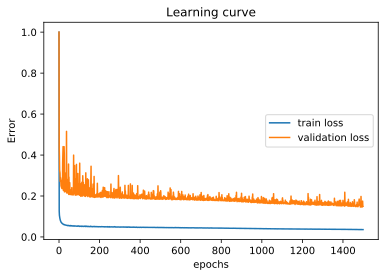

In [25]:
# Plotting the learning curve 
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.plot(history.history['loss']/np.max(history.history['loss']))
plt.plot(history.history['val_loss']/np.max(history.history['val_loss']))
# plt.yscale("log")
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='center right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [26]:
# Predict training and test data using the trained network
test_output = ElasticModel.predict(X_test)
train_output = ElasticModel.predict(X_train)

(1.4, 2.2)

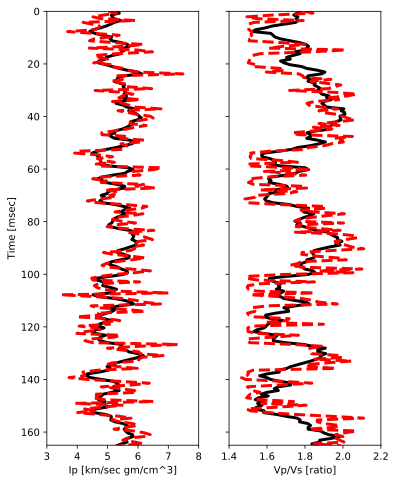

In [27]:
# Checking training data

sample_number = 25
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,8))

axarr[0].plot(train_output[sample_number, 0, :], time_upscaled*1e3, '-k', label='predicted', linewidth=3)
axarr[0].plot(Y_train[sample_number, 0, :], time_upscaled*1e3, '--r', label='true', linewidth=3)
axarr[0].set_xlabel("Ip [km/sec gm/cm^3]")
axarr[0].set_ylabel("Time [msec]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(3,8)
axarr[0].set_ylim(0,165)

axarr[1].plot(train_output[sample_number, 1, :], time_upscaled*1e3, '-k', linewidth=3)
axarr[1].plot(Y_train[sample_number, 1, :], time_upscaled*1e3, '--r', linewidth=3)
axarr[1].set_xlabel("Vp/Vs [ratio]")
# axarr[1].set_ylabel("Time [msec]")
axarr[1].invert_yaxis()
axarr[1].set_xlim(1.4,2.2)

# axarr[2].plot(train_output[sample_number, 2, :], time_upscaled, '-k')
# axarr[2].plot(Y_train[sample_number, 2, :], time_upscaled, '--r')
# axarr[2].set_xlabel("RHOB")
# axarr[2].set_ylabel("Time")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

(1.4, 2.2)

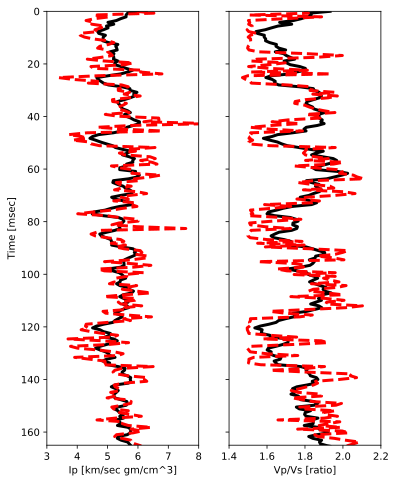

In [29]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,8))

axarr[0].plot(test_output[sample_number, 0, :], time_upscaled*1e3, '-k', label='predicted', linewidth=3)
axarr[0].plot(Y_test[sample_number, 0, :], time_upscaled*1e3, '--r', label='true', linewidth=3)
axarr[0].set_xlabel("Ip [km/sec gm/cm^3]")
axarr[0].set_ylabel("Time [msec]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(3,8)
axarr[0].set_ylim(0,165)

axarr[1].plot(test_output[sample_number, 1, :], time_upscaled*1e3, '-k', linewidth=3)
axarr[1].plot(Y_test[sample_number, 1, :], time_upscaled*1e3, '--r', linewidth=3)
axarr[1].set_xlabel("Vp/Vs [ratio]")
# axarr[1].set_ylabel("Time [msec]")
axarr[1].invert_yaxis()
axarr[1].set_xlim(1.4,2.2)

# axarr[2].plot(test_output[sample_number, 2, :], time_upscaled, '-k')
# axarr[2].plot(Y_test[sample_number, 2, :], time_upscaled, '--r')
# axarr[2].set_xlabel("RHOB")
# axarr[2].set_ylabel("Time")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

In [30]:
# Correlation coefficient between true and predicted traces 

Ip_corr_train = np.zeros(train_output.shape[0])
Vp_Vs_corr_train = np.zeros(train_output.shape[0])
# RHOB_corr_train = np.zeros(train_output.shape[0])
for i in range(train_output.shape[0]):
    Ip_corr_train[i] = np.corrcoef(train_output[i,0,:], Y_train[i,0,:])[0,1]
    Vp_Vs_corr_train[i] = np.corrcoef(train_output[i,1,:], Y_train[i,1,:])[0,1]
#     RHOB_corr_train[i] = np.corrcoef(train_output[i,2,:], Y_train[i,2,:])[0,1]
    
Ip_corr_test = np.zeros(test_output.shape[0])
Vp_Vs_corr_test = np.zeros(test_output.shape[0])
# RHOB_corr_test = np.zeros(test_output.shape[0])
for i in range(test_output.shape[0]):
    Ip_corr_test[i] = np.corrcoef(test_output[i,0,:], Y_test[i,0,:])[0,1]
    Vp_Vs_corr_test[i] = np.corrcoef(test_output[i,1,:], Y_test[i,1,:])[0,1]
#     RHOB_corr_test[i] = np.corrcoef(test_output[i,2,:], Y_test[i,2,:])[0,1]

    
# Average correlation coefficient
print("Average correlation in Ip for training data = ", np.mean(Ip_corr_train))
print("Average correlation in Vp_Vs for training data = ", np.mean(Vp_Vs_corr_train))
# print("Average correlation in RHOB for training data = ", np.mean(RHOB_corr_train))

print("Average correlation in Ip for training data = ", np.mean(Ip_corr_test))
print("Average correlation in Vp_Vs for training data = ", np.mean(Vp_Vs_corr_test))
# print("Average correlation in RHOB for training data = ", np.mean(RHOB_corr_test))

Average correlation in Ip for training data =  0.7519605752877225
Average correlation in Vp_Vs for training data =  0.7750285244422414
Average correlation in Ip for training data =  0.7204856805326704
Average correlation in Vp_Vs for training data =  0.7445625251981468


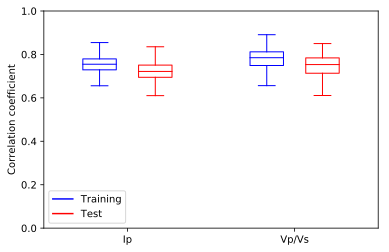

In [31]:
# Box plot of correlation coefficients 

from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
#     setp(bp['fliers'][0], color='blue')
#     setp(bp['fliers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
#     setp(bp['fliers'][2], color='red')
#     setp(bp['fliers'][3], color='red')
    setp(bp['medians'][1], color='red')

A= [Ip_corr_train, Ip_corr_test]
B = [Vp_Vs_corr_train, Vp_Vs_corr_test]
# C = [RHOB_corr_train, RHOB_corr_test]

fig = figure()
ax = axes()

# first boxplot pair
bp = boxplot(A, positions = [1, 2], widths = 0.6, showfliers=False)
setBoxColors(bp)

# second boxplot pair
bp = boxplot(B, positions = [4, 5], widths = 0.6, showfliers=False)
setBoxColors(bp)

# # thrid boxplot pair
# bp = boxplot(C, positions = [7, 8], widths = 0.6, showfliers=False)
# setBoxColors(bp)

# set axes limits and labels
# xlim(0,9)
xlim(0,6)
ylim(0,1)
# ax.set_xticklabels(['Vp', 'Vs', 'RHOB'])
ax.set_xticklabels(['Ip', 'Vp/Vs'])
# ax.set_xticks([1.5, 4.5, 7.5])
ax.set_xticks([1.5, 4.5])
plt.ylabel('Correlation coefficient')

# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('Training', 'Test'), loc='lower left')
hB.set_visible(False)
hR.set_visible(False)

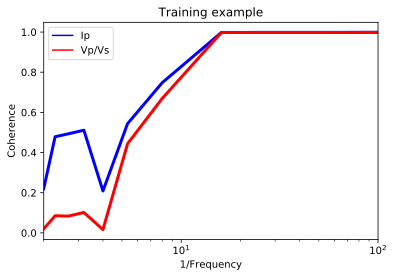

In [33]:
# Spectral coherence between true and predicted (training data)

sample_number = 25
Cxy_ip, wavenumber_ip = plt.cohere(Y_train[sample_number,0,:], train_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vp_vs, wavenumber_vp_vs = plt.cohere(Y_train[sample_number,1,:], train_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_rhob, wavenumber_rhob = plt.cohere(Y_train[sample_number,2,:], train_output[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_ip[0] = wavenumber_ip[0] + 0.001
wavenumber_vp_vs[0] = wavenumber_vp_vs[0] + 0.001
# wavenumber_rhob[0] = wavenumber_rhob[0] + 0.001

plt.plot(1/wavenumber_ip, Cxy_ip, color="blue", linewidth=3)
plt.plot(1/wavenumber_vp_vs, Cxy_vp_vs, color="red", linewidth=3)
# plt.plot(1/wavenumber_rhob, Cxy_rhob, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Vp','Vs', 'RHOB'))
plt.gca().legend(('Ip','Vp/Vs'))
plt.xlabel('1/Frequency')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

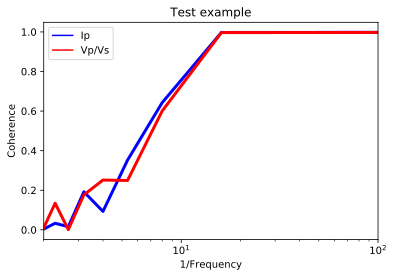

In [34]:
# Spectral coherence between true and predicted (training data)

sample_number = 12
Cxy_ip, wavenumber_ip = plt.cohere(Y_test[sample_number,0,:], test_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vp_vs, wavenumber_vp_vs = plt.cohere(Y_test[sample_number,1,:], test_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_rhob, wavenumber_rhob = plt.cohere(Y_test[sample_number,2,:], test_output[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_ip[0] = wavenumber_ip[0] + 0.001
wavenumber_vp_vs[0] = wavenumber_vp_vs[0] + 0.001
# wavenumber_rhob[0] = wavenumber_rhob[0] + 0.001

plt.plot(1/wavenumber_ip, Cxy_ip, color="blue", linewidth=3)
plt.plot(1/wavenumber_vp_vs, Cxy_vp_vs, color="red", linewidth=3)
# plt.plot(1/wavenumber_rhob, Cxy_rhob, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Vp','Vs', 'RHOB'))
plt.gca().legend(('Ip','Vp/Vs'))
plt.xlabel('1/Frequency')
plt.ylabel('Coherence')
plt.title('Test example')
plt.grid(b=False)

## Predicting petrophysical properties from elastic properties of previous network

In [35]:
# Use predicted Ip, Vp/Vs from network
# Concatenate Ip, Vp/Vs

num_examples = Vp_time.shape[0]
emodel_true = np.concatenate((Vp_time*RHOB_time,Vp_time/Vs_time,), axis=1)
emodel_true = emodel.reshape((num_examples, 2, nt))

# emodel_norm = ElasticModel.predict(np.expand_dims(seis_reshaped_normalized, axis=3))
emodel = ElasticModel.predict(np.expand_dims(angle_seis_reshaped_normalized, axis=3))


# Concatenate Porosity, Vclay
num_examples = porosity.shape[0]
ndepth = porosity.shape[1]

# Normalize porosity
porosity_norm = (porosity - np.min(porosity))/(np.max(porosity) - np.min(porosity))

# petromodel = np.concatenate((porosity,vclay,Sw), axis=1)
# petromodel = petromodel.reshape((num_examples, 3, ndepth))
petromodel = np.concatenate((porosity_norm,vclay), axis=1)
petromodel = petromodel.reshape((num_examples, 2, ndepth))

# Split data into train and test set - elastic model predicted
X_train, X_test, Y_train_norm, Y_test_norm = sklearn.model_selection.train_test_split(emodel, 
                                                                            petromodel, test_size=0.2, random_state=1)

# Split data into train and test set - elastic model true
X_train_true, X_test_true, Y_train_true_norm, Y_test_true_norm = sklearn.model_selection.train_test_split(emodel_true, 
                                                                            petromodel, test_size=0.2, random_state=1)


# Add 4th dimension of number of channels=1 to the input data
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)


print ("number of training examples = " + str(X_train.shape[0]))
# print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train_norm.shape))
# print ("X_val shape: " + str(X_val.shape))
# print ("Y_val shape: " + str(Y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test_norm.shape))

number of training examples = 2000
number of test examples = 500
X_train shape: (2000, 2, 246, 1)
Y_train shape: (2000, 2, 199)
X_test shape: (500, 2, 246, 1)
Y_test shape: (500, 2, 199)


In [36]:
# Building neural network for petrophysical properties prediction in Keras 
given_seed = 3 # For repeatibility

def elastic_petronet(input_shape):
    """
    Implementation of the AVONet.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    

    # Define the input placeholder as a tensor with shape input_shape. Input = input angle gather 
    X_input = Input(input_shape)

    X = X_input

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(8, (1, 30), strides=(1, 2), name='conv0', padding='same',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn0')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv0')(X)
    # MAXPOOL
#     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool0')(X)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(5, (1, 60), strides=(1, 2), name='conv1', padding='same',
               kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
    X = BatchNormalization(axis=-1, name='bn1')(X)
    X = Activation('relu')(X)
    X = Dropout(rate=0.3, name='drop_conv1')(X)
    # MAXPOOL
#     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)

#     # CONV -> BN -> RELU Block applied to X
#     X = Conv2D(16, (1, 30), strides=(1, 2), name='conv2', padding='same',
#                kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
#     X = BatchNormalization(axis=-1, name='bn2')(X)
#     X = Activation('relu')(X)
#     X = Dropout(rate=0.3, name='drop_conv2')(X)
#     # MAXPOOL
# #     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)

#     # CONV -> BN -> RELU Block applied to X
#     X = Conv2D(8, (1, 60), strides=(1, 2), name='conv3', padding='same',
#                kernel_initializer=initializers.he_normal(seed=given_seed), bias_initializer='zeros')(X)
#     X = BatchNormalization(axis=-1, name='bn3')(X)
#     X = Activation('relu')(X)
#     X = Dropout(rate=0.3, name='drop_conv3')(X)
#     # MAXPOOL
# #     X = MaxPooling2D((2, 2), strides=(1,1),name='max_pool1')(X)



    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
#     X = Dense(1200, name='fc1')(X)
#     X = Activation('relu')(X)
    X = Dense(199*2, name='fc1')(X)
    X = Activation('relu')(X)
    
    X = Reshape((2, 199))(X)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='ElasticPetroModel')

    return model
    ### END CODE HERE ###

In [37]:
# Create the model
ElasticPetroModel = elastic_petronet(X_train.shape[1:])

In [38]:
# Summary and plot of the model

ElasticPetroModel.summary()


# plot_model(AVOModel)
# SVG(model_to_dot(ElasticModel).create(prog='dot', format='svg'))
# plot_model(ElasticModel, to_file='./Figures/model_plot.png', show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2, 246, 1)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 2, 123, 8)         248       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 2, 123, 8)         32        
_________________________________________________________________
activation_4 (Activation)    (None, 2, 123, 8)         0         
_________________________________________________________________
drop_conv0 (Dropout)         (None, 2, 123, 8)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 62, 5)          2405      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 2, 62, 5)          20        
__________

In [27]:
# Learning rate scheduler
from keras.callbacks import LearningRateScheduler
# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 50.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [39]:
# Compile the model with optimization algorithm, loss function
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

ElasticPetroModel.compile(loss='mean_squared_error', optimizer = adam)

In [40]:
# Removing previous best_model.h5 file
import os
os.remove("best_model_elastic_petro_near_far.h5")

In [41]:
# Using early stopping and Model Checkpoint
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
mc = ModelCheckpoint('best_model_elastic_petro_near_far.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [42]:
# Start the training
# Using learning rate scheduler
# lrate = LearningRateScheduler(step_decay)
# callbacks_list = [es, mc, lrate]
# history = ElasticModel.fit(X_train, Y_train, validation_split=0.2, 
#                            epochs=1500, batch_size=32, callbacks=callbacks_list, verbose=0)

history = ElasticPetroModel.fit(X_train, Y_train_norm, validation_split=0.2, 
                           epochs=1500, batch_size=32, callbacks=[es, mc],
                          verbose = 0)


Epoch 00001: val_loss improved from inf to 0.14430, saving model to best_model_elastic_petro_near_far.h5

Epoch 00002: val_loss improved from 0.14430 to 0.11875, saving model to best_model_elastic_petro_near_far.h5

Epoch 00003: val_loss improved from 0.11875 to 0.09658, saving model to best_model_elastic_petro_near_far.h5

Epoch 00004: val_loss improved from 0.09658 to 0.08552, saving model to best_model_elastic_petro_near_far.h5

Epoch 00005: val_loss improved from 0.08552 to 0.08156, saving model to best_model_elastic_petro_near_far.h5

Epoch 00006: val_loss improved from 0.08156 to 0.07751, saving model to best_model_elastic_petro_near_far.h5

Epoch 00007: val_loss improved from 0.07751 to 0.07188, saving model to best_model_elastic_petro_near_far.h5

Epoch 00008: val_loss improved from 0.07188 to 0.07053, saving model to best_model_elastic_petro_near_far.h5

Epoch 00009: val_loss improved from 0.07053 to 0.06812, saving model to best_model_elastic_petro_near_far.h5

Epoch 00010: 


Epoch 00127: val_loss improved from 0.03508 to 0.03488, saving model to best_model_elastic_petro_near_far.h5

Epoch 00128: val_loss did not improve from 0.03488

Epoch 00129: val_loss did not improve from 0.03488

Epoch 00130: val_loss did not improve from 0.03488

Epoch 00131: val_loss did not improve from 0.03488

Epoch 00132: val_loss did not improve from 0.03488

Epoch 00133: val_loss did not improve from 0.03488

Epoch 00134: val_loss did not improve from 0.03488

Epoch 00135: val_loss did not improve from 0.03488

Epoch 00136: val_loss did not improve from 0.03488

Epoch 00137: val_loss did not improve from 0.03488

Epoch 00138: val_loss did not improve from 0.03488

Epoch 00139: val_loss did not improve from 0.03488

Epoch 00140: val_loss did not improve from 0.03488

Epoch 00141: val_loss did not improve from 0.03488

Epoch 00142: val_loss did not improve from 0.03488

Epoch 00143: val_loss did not improve from 0.03488

Epoch 00144: val_loss did not improve from 0.03488

Epoch

In [43]:
# load the saved model
ElasticPetroModel = load_model('best_model_elastic_petro_near_far.h5')

In [44]:
# Testing and evaluating the model
preds = ElasticPetroModel.evaluate(X_test, Y_test_norm, batch_size=32, verbose=0, sample_weight=None)
print()
print ("Loss = " + str(preds))
# print ("Test Accuracy = " + str(preds[1]))


Loss = 0.03515373116731644


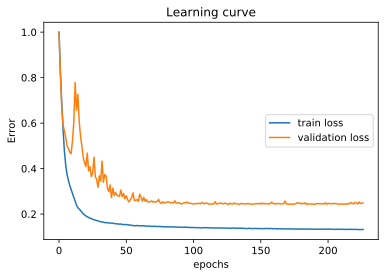

In [45]:
# Plotting the learning curve 
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.plot(history.history['loss']/np.max(history.history['loss']))
plt.plot(history.history['val_loss']/np.max(history.history['val_loss']))
# plt.yscale("log")
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])


plt.title('Learning curve')
# plt.ylabel('Error/Accuracy')
plt.ylabel('Error')
plt.xlabel('epochs')
plt.legend(['train loss', 'validation loss'], loc='center right')
# plt.savefig('/Figures/learning_curve_08Nov.png', bbox_inches='tight')

In [46]:
# Predict training and test data using the trained network
test_output_norm = ElasticPetroModel.predict(X_test)
train_output_norm = ElasticPetroModel.predict(X_train)

# Initialization
train_output = np.zeros(train_output_norm.shape)
test_output = np.zeros(test_output_norm.shape)
Y_train = np.zeros(Y_train_norm.shape)
Y_test = np.zeros(Y_test_norm.shape)

# Back transforming porosity to unnormalized values 
train_output[:,0,:] = train_output_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)
test_output[:,0,:] = test_output_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)

train_output[:,1,:] = train_output_norm[:,1,:]
test_output[:,1,:] = test_output_norm[:,1,:]

Y_train[:,0,:] = Y_train_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)
Y_test[:,0,:] = Y_test_norm[:,0,:]*(np.max(porosity) - np.min(porosity)) + np.min(porosity)

Y_train[:,1,:] = Y_train_norm[:,1,:]
Y_test[:,1,:] = Y_test_norm[:,1,:]

In [70]:
# RMSE with respect to mean 
rmse_train = np.sqrt(np.mean(((train_output - Y_train)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_train, axis = 0), axis=1)
rmse_test = np.sqrt(np.mean(((test_output - Y_test)**2).mean(axis=2), axis = 0))/np.mean(np.mean(Y_test, axis = 0), axis=1)

print("Training error = ", rmse_train)
print("Test error = ", rmse_test)

Training error =  [0.17795548 0.34605713]
Test error =  [0.18924002 0.37196291]


(0, 1)

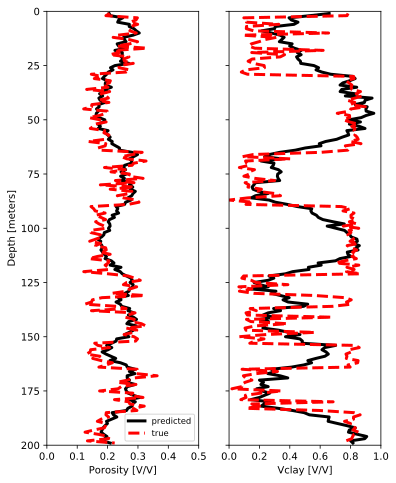

In [47]:
# Checking training data

sample_number = 25
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,8))

axarr[0].plot(train_output[sample_number, 0, :], depth, '-k', label='predicted', linewidth=3)
axarr[0].plot(Y_train[sample_number, 0, :], depth, '--r', label='true', linewidth=3)
axarr[0].set_xlabel("Porosity [V/V]")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0,0.5)
axarr[0].set_ylim(0,200)
axarr[0].legend(fontsize = 'small')

axarr[1].plot(train_output[sample_number, 1, :], depth, '-k', linewidth=3)
axarr[1].plot(Y_train[sample_number, 1, :], depth, '--r', linewidth=3)
axarr[1].set_xlabel("Vclay [V/V]")
# axarr[1].set_ylabel("Depth [meters]")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

# axarr[2].plot(train_output[sample_number, 2, :], depth, '-k')
# axarr[2].plot(Y_train[sample_number, 2, :], depth, '--r')
# axarr[2].set_xlabel("Sw")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

(0, 1)

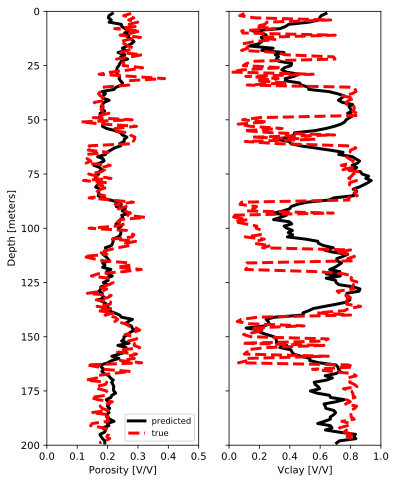

In [48]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,8))

axarr[0].plot(test_output[sample_number, 0, :], depth, '-k', label='predicted', linewidth=3)
axarr[0].plot(Y_test[sample_number, 0, :], depth, '--r', label='true', linewidth=3)
axarr[0].set_xlabel("Porosity [V/V]")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0,0.5)
axarr[0].set_ylim(0,200)
axarr[0].legend(fontsize = 'small')

axarr[1].plot(test_output[sample_number, 1, :], depth, '-k', linewidth=3)
axarr[1].plot(Y_test[sample_number, 1, :], depth, '--r', linewidth=3)
axarr[1].set_xlabel("Vclay [V/V]")
# axarr[1].set_ylabel("Depth [meters]")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

# axarr[2].plot(test_output[sample_number, 2, :], depth, '-k')
# axarr[2].plot(Y_test[sample_number, 2, :], depth, '--r')
# axarr[2].set_xlabel("Sw")
# axarr[2].set_ylabel("Depth")
# axarr[2].invert_yaxis()
# axarr[2].set_xlim(1.5,3)

In [49]:
# Correlation coefficient between true and predicted traces 

Porosity_corr_train = np.zeros(train_output.shape[0])
Vclay_corr_train = np.zeros(train_output.shape[0])
# Sw_corr_train = np.zeros(train_output.shape[0])
for i in range(train_output.shape[0]):
    Porosity_corr_train[i] = np.corrcoef(train_output[i,0,:], Y_train[i,0,:])[0,1]
    Vclay_corr_train[i] = np.corrcoef(train_output[i,1,:], Y_train[i,1,:])[0,1]
#     Sw_corr_train[i] = np.corrcoef(train_output[i,2,:], Y_train[i,2,:])[0,1]
    
Porosity_corr_test = np.zeros(test_output.shape[0])
Vclay_corr_test = np.zeros(test_output.shape[0])
# Sw_corr_test = np.zeros(test_output.shape[0])
for i in range(test_output.shape[0]):
    Porosity_corr_test[i] = np.corrcoef(test_output[i,0,:], Y_test[i,0,:])[0,1]
    Vclay_corr_test[i] = np.corrcoef(test_output[i,1,:], Y_test[i,1,:])[0,1]
#     Sw_corr_test[i] = np.corrcoef(test_output[i,2,:], Y_test[i,2,:])[0,1]

    
# Average correlation coefficient
print("Average correlation in porosity for training data = ", np.mean(Porosity_corr_train))
print("Average correlation in Vclay for training data = ", np.mean(Vclay_corr_train))
# print("Average correlation in Sw for training data = ", np.mean(Sw_corr_train))

print("Average correlation in porosity for test data = ", np.mean(Porosity_corr_test))
print("Average correlation in Vclay for test data = ", np.mean(Vclay_corr_test))
# print("Average correlation in Sw for test data = ", np.mean(Sw_corr_test))

Average correlation in porosity for training data =  0.6871395222057451
Average correlation in Vclay for training data =  0.7358207752322867
Average correlation in porosity for test data =  0.6122624585891283
Average correlation in Vclay for test data =  0.6693792913965403


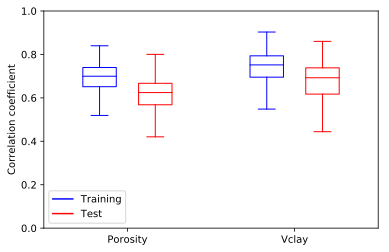

In [50]:
# Box plot of correlation coefficients 

from pylab import plot, show, savefig, xlim, figure, \
                hold, ylim, legend, boxplot, setp, axes

# function for setting the colors of the box plots pairs
def setBoxColors(bp):
    setp(bp['boxes'][0], color='blue')
    setp(bp['caps'][0], color='blue')
    setp(bp['caps'][1], color='blue')
    setp(bp['whiskers'][0], color='blue')
    setp(bp['whiskers'][1], color='blue')
#     setp(bp['fliers'][0], color='blue')
#     setp(bp['fliers'][1], color='blue')
    setp(bp['medians'][0], color='blue')

    setp(bp['boxes'][1], color='red')
    setp(bp['caps'][2], color='red')
    setp(bp['caps'][3], color='red')
    setp(bp['whiskers'][2], color='red')
    setp(bp['whiskers'][3], color='red')
#     setp(bp['fliers'][2], color='red')
#     setp(bp['fliers'][3], color='red')
    setp(bp['medians'][1], color='red')

# Some fake data to plot
A= [Porosity_corr_train, Porosity_corr_test]
B = [Vclay_corr_train, Vclay_corr_test]
# C = [Sw_corr_train, Sw_corr_test]

fig = figure()
ax = axes()

# first boxplot pair
bp = boxplot(A, positions = [1, 2], widths = 0.6, showfliers=False)
setBoxColors(bp)

# second boxplot pair
bp = boxplot(B, positions = [4, 5], widths = 0.6, showfliers=False)
setBoxColors(bp)

# thrid boxplot pair
# bp = boxplot(C, positions = [7, 8], widths = 0.6, showfliers=False)
# setBoxColors(bp)

# set axes limits and labels
# xlim(0,9)
xlim(0,6)
ylim(0,1)
# ax.set_xticklabels(['Porosity', 'Vclay', 'Sw'])
ax.set_xticklabels(['Porosity', 'Vclay'])
# ax.set_xticks([1.5, 4.5, 7.5])
ax.set_xticks([1.5, 4.5])
plt.ylabel('Correlation coefficient')

# draw temporary red and blue lines and use them to create a legend
hB, = plot([1,1],'b-')
hR, = plot([1,1],'r-')
legend((hB, hR),('Training', 'Test'), loc='lower left')
hB.set_visible(False)
hR.set_visible(False)

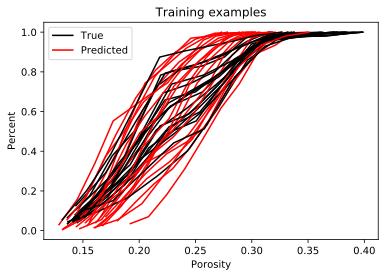

In [84]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    hist, bin_edges = np.histogram(Y_train[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(train_output[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
#     plt.hist(train_output[i,0,:], histtype='step', color='red')
    plt.xlabel('Porosity')
    plt.ylabel('Probability')
    plt.title('Training examples')

plt.legend(['True', 'Predicted'])




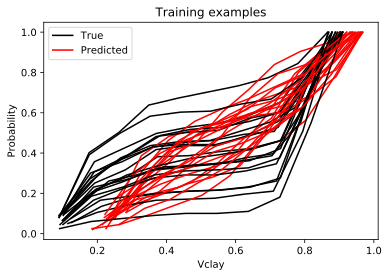

In [86]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    hist, bin_edges = np.histogram(Y_train[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(train_output[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Vclay')
    plt.ylabel('Probability')
    plt.title('Training examples')
    
plt.legend(['True', 'Predicted'])

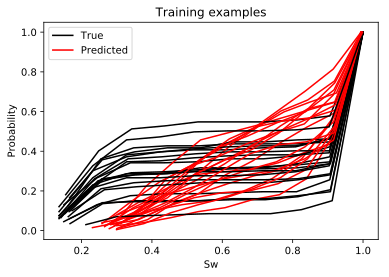

In [88]:
# Histogram plot for true vs predicted values
for i in np.arange(0,train_output.shape[0],100):
    hist, bin_edges = np.histogram(Y_train[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(train_output[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Sw')
    plt.ylabel('Probability')
    plt.title('Training examples')
plt.legend(['True', 'Predicted'])

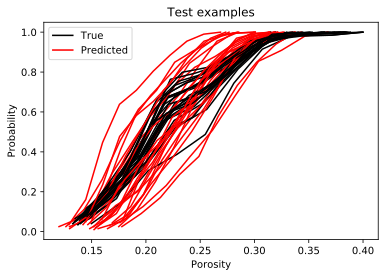

In [94]:
for i in np.arange(0,test_output.shape[0],20):
    hist, bin_edges = np.histogram(Y_test[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(test_output[i,0,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Porosity')
    plt.ylabel('Probability')
    plt.title('Test examples')
plt.legend(['True', 'Predicted'])    

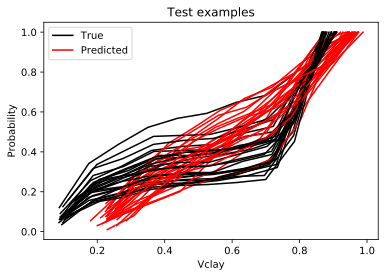

In [95]:
for i in np.arange(0,test_output.shape[0],20):
    hist, bin_edges = np.histogram(Y_test[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(test_output[i,1,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Vclay')
    plt.ylabel('Probability')
    plt.title('Test examples')
    
plt.legend(['True', 'Predicted'])

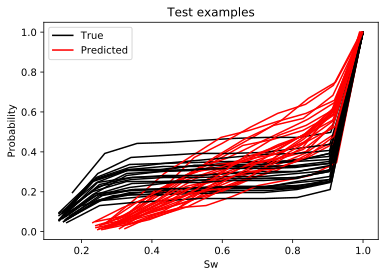

In [96]:
for i in np.arange(0,test_output.shape[0],20):
    hist, bin_edges = np.histogram(Y_test[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="black")
    hist, bin_edges = np.histogram(test_output[i,2,:], density=True)
    plt.plot(bin_edges[1:],np.cumsum(hist)*(bin_edges[1]-bin_edges[0]), color="red")
    plt.xlabel('Sw')
    plt.ylabel('Probability')
    plt.title('Test examples')
    
plt.legend(['True', 'Predicted'])

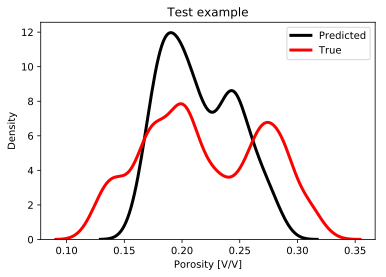

In [52]:
# Density estimate for true vs predicted (test example) Porosity

import seaborn as sns

sample_number = 12
sns.kdeplot(test_output[sample_number,0,:],  
             color='black', label='Predicted', linewidth=3,
            bw=0.01,
             clip=(np.min(test_output[sample_number,0,:]), np.max(test_output[sample_number,0,:])))
sns.kdeplot(Y_test[sample_number,0,:],  
             color='red', label='True', linewidth=3,
            bw=0.01,
             clip=(np.min(Y_test[sample_number,0,:]), np.max(Y_test[sample_number,0,:])))
plt.xlabel('Porosity [V/V]')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()

(-0.1, 1.1)

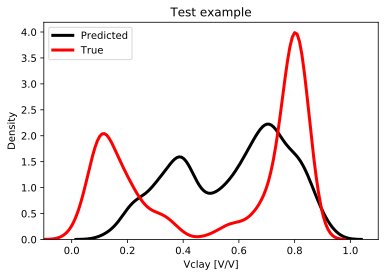

In [53]:
# Density estimate for true vs predicted (test example) Vclay

sample_number = 12

sns.kdeplot(test_output[sample_number,1,:],  
             color='black', label='Predicted', linewidth=3,
             bw=0.04,
           clip=(np.min(test_output[sample_number,1,:]), np.max(test_output[sample_number,1,:])))
sns.kdeplot(Y_test[sample_number,1,:],  
             color='red', label='True', linewidth=3,
            bw=0.04,
             clip=(np.min(Y_test[sample_number,1,:]), np.max(Y_test[sample_number,1,:])))
plt.xlabel('Vclay [V/V]')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()
plt.xlim(-0.1,1.1)

(-0.1, 1.1)

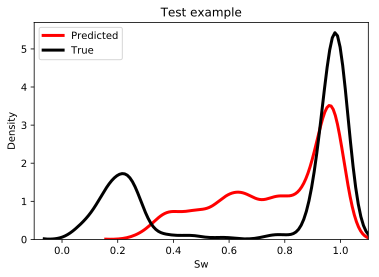

In [39]:
# Density estimate for true vs predicted (test example) Water saturation 

sample_number = 12

sns.kdeplot(test_output[sample_number,2,:],  
             color='red', label='Predicted', linewidth=3,
             bw=0.04,
           clip=(np.min(test_output[sample_number,2,:]), np.max(test_output[sample_number,2,:])))
sns.kdeplot(Y_test[sample_number,2,:],  
             color='black', label='True', linewidth=3,
            bw=0.04,
             clip=(np.min(Y_test[sample_number,2,:]), np.max(Y_test[sample_number,2,:])))
plt.xlabel('Sw')
plt.ylabel('Density')
plt.title('Test example')
plt.legend()
plt.xlim(-0.1,1.1)

({'var': 0.008288709773796135,
  'len_scale': 853.3274762472248,
  'nugget': 0.0006671958519108878},
 array([[3.93398497e+00, 4.05809072e+05, 1.49197102e-04],
        [4.05809072e+05, 4.18611478e+10, 1.54034973e+01],
        [1.49197102e-04, 1.54034973e+01, 1.29551329e-08]]))

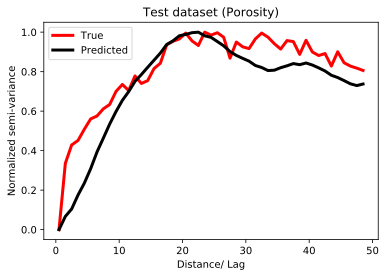

In [55]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red",linewidth=3)
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Porosity)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output[sample_number,0,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black",linewidth=3)
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

({'var': 0.04740744619254697,
  'len_scale': 21.78521720509975,
  'nugget': 1.1575481959120072e-27},
 array([[ 6.76278503e-06, -1.58362937e-03, -6.21062310e-06],
        [-1.58362937e-03,  2.27023368e+00,  2.14392496e-03],
        [-6.21062310e-06,  2.14392496e-03,  6.38903630e-06]]))

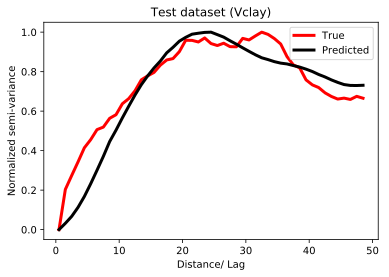

In [56]:
# Compute variograms for true and predicted data

from gstools import vario_estimate_unstructured, Spherical
from gstools.covmodel.plot import plot_variogram

# estimate the variogram of the field with 40 bins
bins = np.arange(50)

sample_number = 12
bin_center, gamma = vario_estimate_unstructured(depth.T, Y_test[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="red",linewidth=3)
plt.xlabel('Distance/ Lag')
plt.ylabel('Normalized semi-variance')
plt.title('Test dataset (Vclay)')
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])
    
bin_center, gamma = vario_estimate_unstructured(depth.T, test_output[sample_number,1,:], bins)
plt.plot(bin_center, gamma/np.max(gamma), color="black",linewidth=3)
plt.gca().legend(('True','Predicted'))
# fit the variogram with a stable model. (no nugget fitted)
fit_model = Spherical(dim=1)
fit_model.fit_variogram(bin_center, gamma, nugget=True)
# plot_variogram(fit_model, x_max=bins[-1])

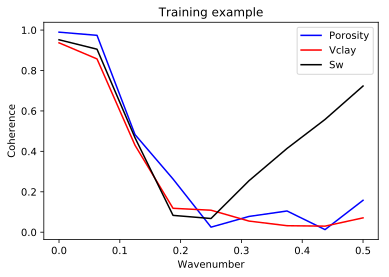

In [36]:
# Spectral coherence between true and predicted 

sample_number = 25
plt.cohere(Y_train[sample_number,0,:], train_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
plt.cohere(Y_train[sample_number,1,:], train_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
plt.cohere(Y_train[sample_number,2,:], train_output[sample_number,2,:], NFFT=16, Fs=1, color="black")


plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.xlabel('Wavenumber')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

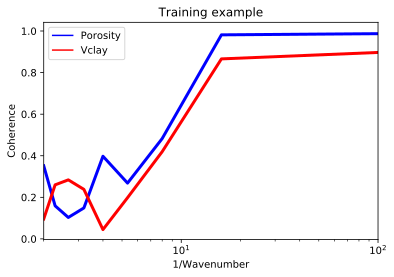

In [57]:
# Spectral coherence between true and predicted (training data)

sample_number = 25
Cxy_poro, wavenumber_poro = plt.cohere(Y_train[sample_number,0,:], train_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vclay, wavenumber_vclay = plt.cohere(Y_train[sample_number,1,:], train_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_sw, wavenumber_sw = plt.cohere(Y_test_petro[sample_number,2,:], test_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_poro[0] = wavenumber_poro[0] + 0.001
wavenumber_vclay[0] = wavenumber_vclay[0] + 0.001
# wavenumber_sw[0] = wavenumber_sw[0] + 0.001

plt.plot(1/wavenumber_poro, Cxy_poro, color="blue", linewidth=3)
plt.plot(1/wavenumber_vclay, Cxy_vclay, color="red", linewidth=3)
# plt.plot(1/wavenumber_sw, Cxy_sw, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('1/Wavenumber')
plt.ylabel('Coherence')
plt.title('Training example')
plt.grid(b=False)

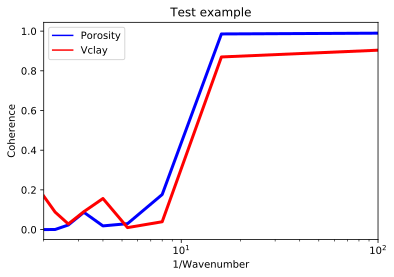

In [58]:
# Spectral coherence between true and predicted (test data)

sample_number = 12
Cxy_poro, wavenumber_poro = plt.cohere(Y_test[sample_number,0,:], test_output[sample_number,0,:], NFFT=16, Fs=1, color="blue")
Cxy_vclay, wavenumber_vclay = plt.cohere(Y_test[sample_number,1,:], test_output[sample_number,1,:], NFFT=16, Fs=1, color="red") 
# Cxy_sw, wavenumber_sw = plt.cohere(Y_test_petro[sample_number,2,:], test_output_petro[sample_number,2,:], NFFT=16, Fs=1, color="black")

# Adding epsilon to the first wavenumber value
wavenumber_poro[0] = wavenumber_poro[0] + 0.001
wavenumber_vclay[0] = wavenumber_vclay[0] + 0.001
# wavenumber_sw[0] = wavenumber_sw[0] + 0.001

plt.plot(1/wavenumber_poro, Cxy_poro, color="blue", linewidth=3)
plt.plot(1/wavenumber_vclay, Cxy_vclay, color="red", linewidth=3)
# plt.plot(1/wavenumber_sw, Cxy_sw, color="black")

plt.xlim(100,2)
plt.gca().invert_xaxis()
plt.xscale("log")

# plt.gca().legend(('Porosity','Vclay', 'Sw'))
plt.gca().legend(('Porosity','Vclay'))
plt.xlabel('1/Wavenumber')
plt.ylabel('Coherence')
plt.title('Test example')
plt.grid(b=False)

(0, 1)

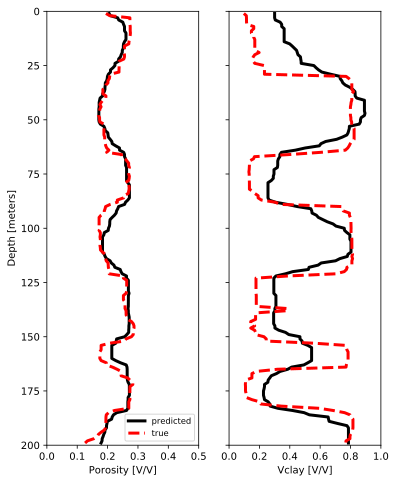

In [60]:
import scipy.signal as sp


# Checking training data (smoothed)

sample_number = 25
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,8))

ker_width = 15

axarr[0].plot(sp.medfilt(train_output[sample_number, 0, :],ker_width), depth, '-k', label='predicted', linewidth=3)
axarr[0].plot(sp.medfilt(Y_train[sample_number, 0, :], ker_width), depth, '--r',  label='true', linewidth=3)
axarr[0].set_xlabel("Porosity [V/V]")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0,0.5)
axarr[0].set_ylim(0,200)
axarr[0].legend(fontsize='small')

axarr[1].plot(sp.medfilt(train_output[sample_number, 1, :], ker_width), depth, '-k', linewidth=3)
axarr[1].plot(sp.medfilt(Y_train[sample_number, 1, :],ker_width), depth, '--r', linewidth=3)
axarr[1].set_xlabel("Vclay [V/V]")
# axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

In [61]:
por_corr_coeff_smooth_train = np.corrcoef(sp.medfilt(train_output[sample_number, 0, :],ker_width),
                                                     sp.medfilt(Y_train[sample_number, 0, :], ker_width))
                                          
vclay_corr_coeff_smooth_train = np.corrcoef(sp.medfilt(train_output[sample_number, 1, :],ker_width),
                                                     sp.medfilt(Y_train[sample_number, 1, :], ker_width))

print("Correlation coefficient between smoothed true and predicted porosity for training example = ", 
     '%.3f'%(por_corr_coeff_smooth_train[0,1]))
print("Correlation coefficient between smoothed true and predicted vclay for training example = ", 
     '%.3f'%(vclay_corr_coeff_smooth_train[0,1]))

Correlation coefficient between smoothed true and predicted porosity for training example =  0.875
Correlation coefficient between smoothed true and predicted vclay for training example =  0.857


(0, 1)

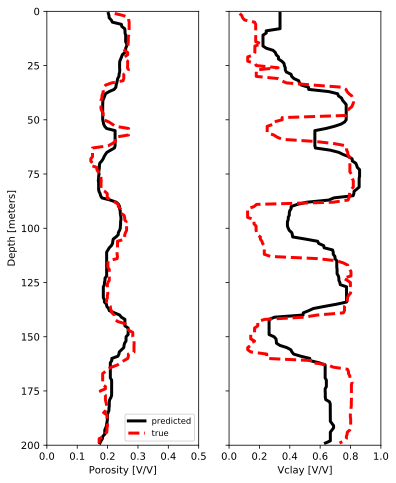

In [62]:
# Checking testing data (smoothed)

sample_number = 12
f, axarr = plt.subplots(1, 2, sharey = True, figsize=(6,8))

ker_width = 15

axarr[0].plot(sp.medfilt(test_output[sample_number, 0, :],ker_width), depth, '-k', label='predicted', linewidth=3)
axarr[0].plot(sp.medfilt(Y_test[sample_number, 0, :], ker_width), depth, '--r',  label='true', linewidth=3)
axarr[0].set_xlabel("Porosity [V/V]")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0,0.5)
axarr[0].set_ylim(0,200)
axarr[0].legend(fontsize='small')

axarr[1].plot(sp.medfilt(test_output[sample_number, 1, :],ker_width), depth, '-k', linewidth=3)
axarr[1].plot(sp.medfilt(Y_test[sample_number, 1, :],ker_width), depth, '--r', linewidth=3)
axarr[1].set_xlabel("Vclay [V/V]")
# axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

In [63]:
por_corr_coeff_smooth_test = np.corrcoef(sp.medfilt(test_output[sample_number, 0, :],ker_width),
                                                     sp.medfilt(Y_test[sample_number, 0, :], ker_width))
                                          
vclay_corr_coeff_smooth_test = np.corrcoef(sp.medfilt(test_output[sample_number, 1, :],ker_width),
                                                     sp.medfilt(Y_test[sample_number, 1, :], ker_width))

print("Correlation coefficient between smoothed true and predicted porosity for test example = ", 
     '%.3f'%(por_corr_coeff_smooth_test[0,1]))
print("Correlation coefficient between smoothed true and predicted vclay for test example = ", 
     '%.3f'%(vclay_corr_coeff_smooth_test[0,1]))

Correlation coefficient between smoothed true and predicted porosity for test example =  0.813
Correlation coefficient between smoothed true and predicted vclay for test example =  0.822


In [64]:
# Uncertainty estimation using dropout
class KerasDropoutPrediction(object):
    def __init__(self,model):
        self.f = K.function(
                [model.layers[0].input, 
                 K.learning_phase()],
                [model.layers[-1].output])
    def predict(self,x, n_iter=10):
        result = []
        for _ in range(n_iter):
            result.append(self.f([x , 1]))
#         result = np.array(result).reshape(n_iter,len(x)).T
        return result

In [65]:
# Uncertainty estimation for training data 

kdp = KerasDropoutPrediction(ElasticPetroModel)
nsim = 1000
Y_train_uncertainty = np.array(kdp.predict(X_train,nsim))
Y_train_uncertainty_reshaped = np.reshape(
    Y_train_uncertainty, (nsim, Y_train.shape[0], Y_train.shape[1], Y_train.shape[2]))


Y_train_uncertainty_reshaped_p50_norm = np.percentile(Y_train_uncertainty_reshaped, 50, axis=0)
Y_train_uncertainty_reshaped_p50 = Y_train_uncertainty_reshaped_p50_norm
Y_train_uncertainty_reshaped_p50[:,0,:] = Y_train_uncertainty_reshaped_p50_norm[:,0,:]*(
    np.max(porosity) - np.min(porosity)) + np.min(porosity)

Y_train_uncertainty_reshaped_p5_norm = np.percentile(Y_train_uncertainty_reshaped, 5, axis=0)
Y_train_uncertainty_reshaped_p5 = Y_train_uncertainty_reshaped_p5_norm
Y_train_uncertainty_reshaped_p5[:,0,:] = Y_train_uncertainty_reshaped_p5_norm[:,0,:]*(
    np.max(porosity) - np.min(porosity)) + np.min(porosity)

Y_train_uncertainty_reshaped_p95_norm = np.percentile(Y_train_uncertainty_reshaped, 95, axis=0)
Y_train_uncertainty_reshaped_p95 = Y_train_uncertainty_reshaped_p95_norm
Y_train_uncertainty_reshaped_p95[:,0,:] = Y_train_uncertainty_reshaped_p95_norm[:,0,:]*(
    np.max(porosity) - np.min(porosity)) + np.min(porosity)


(0, 1)

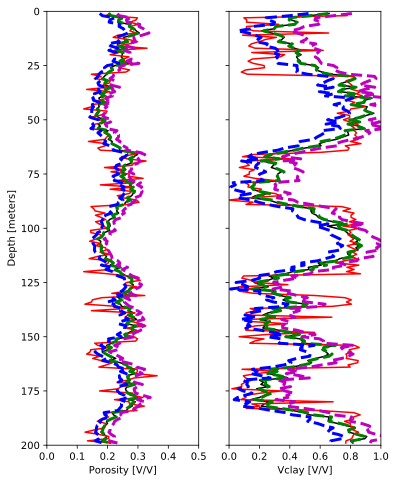

In [66]:
# Checking training data

sample_number = 25
f, axarr = plt.subplots(1, 2, sharey = True, figsize = (6,8))

axarr[0].plot(train_output[sample_number, 0, :], depth, '-k', label='predicted')
axarr[0].plot(Y_train[sample_number, 0, :], depth, '-r', label='true')
axarr[0].plot(Y_train_uncertainty_reshaped_p50[sample_number, 0, :], depth, '--g', label='p50', linewidth = 3)
axarr[0].plot(Y_train_uncertainty_reshaped_p5[sample_number, 0, :], depth, '--b', label='p5', linewidth = 3)
axarr[0].plot(Y_train_uncertainty_reshaped_p95[sample_number, 0, :], depth, '--m', label='p95', linewidth = 3)
axarr[0].set_xlabel("Porosity [V/V]")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0,0.5)
axarr[0].set_ylim(0,200)
# axarr[0].legend(fontsize = 'small')

axarr[1].plot(train_output[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_train[sample_number, 1, :], depth, '-r')
axarr[1].plot(Y_train_uncertainty_reshaped_p50[sample_number, 1, :], depth, '--g', linewidth = 3)
axarr[1].plot(Y_train_uncertainty_reshaped_p5[sample_number, 1, :], depth, '--b', linewidth = 3)
axarr[1].plot(Y_train_uncertainty_reshaped_p95[sample_number, 1, :], depth, '--m', linewidth = 3)
axarr[1].set_xlabel("Vclay [V/V]")
# axarr[1].set_ylabel("Depth [meters]")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)


In [67]:
# Uncertainty estimation for test data 

kdp = KerasDropoutPrediction(ElasticPetroModel)
nsim = 1000
Y_test_uncertainty = np.array(kdp.predict(X_test,nsim))
Y_test_uncertainty_reshaped = np.reshape(
    Y_test_uncertainty, (nsim, Y_test.shape[0], Y_test.shape[1], Y_test.shape[2]))


Y_test_uncertainty_reshaped_p50_norm = np.percentile(Y_test_uncertainty_reshaped, 50, axis=0)
Y_test_uncertainty_reshaped_p50 = Y_test_uncertainty_reshaped_p50_norm
Y_test_uncertainty_reshaped_p50[:,0,:] = Y_test_uncertainty_reshaped_p50_norm[:,0,:]*(
    np.max(porosity) - np.min(porosity)) + np.min(porosity)

Y_test_uncertainty_reshaped_p5_norm = np.percentile(Y_test_uncertainty_reshaped, 5, axis=0)
Y_test_uncertainty_reshaped_p5 = Y_test_uncertainty_reshaped_p5_norm
Y_test_uncertainty_reshaped_p5[:,0,:] = Y_test_uncertainty_reshaped_p5_norm[:,0,:]*(
    np.max(porosity) - np.min(porosity)) + np.min(porosity)

Y_test_uncertainty_reshaped_p95_norm = np.percentile(Y_test_uncertainty_reshaped, 95, axis=0)
Y_test_uncertainty_reshaped_p95 = Y_test_uncertainty_reshaped_p95_norm
Y_test_uncertainty_reshaped_p95[:,0,:] = Y_test_uncertainty_reshaped_p95_norm[:,0,:]*(
    np.max(porosity) - np.min(porosity)) + np.min(porosity)

(0, 1)

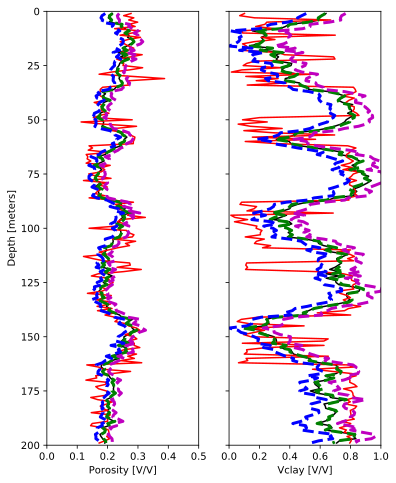

In [68]:
# Checking testing data

sample_number = 12
f, axarr = plt.subplots(1, 2, sharey = True, figsize = (6,8))

axarr[0].plot(test_output[sample_number, 0, :], depth, '-k', label='predicted')
axarr[0].plot(Y_test[sample_number, 0, :], depth, '-r', label='true')
axarr[0].plot(Y_test_uncertainty_reshaped_p50[sample_number, 0, :], depth, '--g', label='p50', linewidth = 3)
axarr[0].plot(Y_test_uncertainty_reshaped_p5[sample_number, 0, :], depth, '--b', label='p5', linewidth = 3)
axarr[0].plot(Y_test_uncertainty_reshaped_p95[sample_number, 0, :], depth, '--m', label='p95', linewidth = 3)
axarr[0].set_xlabel("Porosity [V/V]")
axarr[0].set_ylabel("Depth [meters]")
axarr[0].invert_yaxis()
axarr[0].set_xlim(0,0.5)
axarr[0].set_ylim(0,200)
# axarr[0].legend(fontsize = 'small')

axarr[1].plot(test_output[sample_number, 1, :], depth, '-k')
axarr[1].plot(Y_test[sample_number, 1, :], depth, '-r')
axarr[1].plot(Y_test_uncertainty_reshaped_p50[sample_number, 1, :], depth, '--g', linewidth = 3)
axarr[1].plot(Y_test_uncertainty_reshaped_p5[sample_number, 1, :], depth, '--b', linewidth = 3)
axarr[1].plot(Y_test_uncertainty_reshaped_p95[sample_number, 1, :], depth, '--m', linewidth = 3)
axarr[1].set_xlabel("Vclay [V/V]")
# axarr[1].set_ylabel("Depth")
axarr[1].invert_yaxis()
axarr[1].set_xlim(0,1)

